# Credit Scorecard development case study

## Import Dependencies

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, precision_recall_curve, auc
from sklearn.feature_selection import f_classif
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None


## Data Loading and Overview

In [31]:
data = pd.read_csv('data/loan_data_2007_2014.csv')

In [32]:
# data.head()
data.sample(10)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
418397,13038704,15070880,10000,10000,10000.00000,36 months,13.65,340.08,C,C1,foreman,10+ years,MORTGAGE,58000.0,Source Verified,Apr-14,Charged Off,n,https://www.lendingclub.com/browse/loanDetail....,NaN,major_purchase,Major purchase,782xx,TX,19.68,0.0,Apr-03,2.0,24.0,NaN,7.0,0.0,1970,39.4,17.0,w,0.00,0.00,5101.20000,5101.20,3679.06,1422.14,0.0,0.0,0.0,Jul-15,340.08,NaN,Jan-16,0.0,25.0,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,45029.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5000.0,NaN,NaN,NaN
283911,30425716,32968889,8000,8000,8000.00000,36 months,15.61,279.72,D,D1,overnight stocker,7 years,RENT,29654.0,Verified,Oct-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,other,Other,945xx,CA,5.95,1.0,Oct-08,0.0,14.0,NaN,4.0,0.0,4205,53.2,4.0,w,5321.71,5321.71,3909.14000,3909.14,2678.29,1230.85,0.0,0.0,0.0,Jan-16,279.72,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,4205.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7900.0,NaN,NaN,NaN
269273,32509422,35122682,6000,6000,6000.00000,36 months,8.39,189.10,A,A5,certified final auditor,2 years,RENT,29000.0,Not Verified,Oct-14,Current,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Debt consolidation,130xx,NY,16.84,0.0,Dec-06,0.0,NaN,NaN,8.0,0.0,5337,55.0,13.0,w,3843.61,3843.61,2653.45000,2653.45,2156.39,497.06,0.0,0.0,0.0,Jan-16,189.10,Feb-16,Jan-16,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,18624.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9700.0,NaN,NaN,NaN
208963,1406803,1656008,23850,23850,23850.00000,36 months,13.11,804.87,B,B4,Brightlight Consulting,1 year,MORTGAGE,170000.0,Not Verified,Jul-12,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 07/06/12 > I have been wor...,debt_consolidation,Debt Consolidation 2012,980xx,WA,11.60,0.0,Jul-94,0.0,NaN,NaN,10.0,0.0,25855,65.5,40.0,f,0.00,0.00,28806.33547,28806.34,23850.00,4956.34,0.0,0.0,0.0,Mar-15,2268.60,NaN,Feb-15,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29509,516021,666980,15000,14075,13908.60956,36 months,7.88,440.29,A,A5,St Croix Press,7 years,MORTGAGE,78000.0,Verified,Jun-10,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,Borrower added on 05/25/10 > Our son lost hi...,other,debt_consolidation,553xx,MN,9.42,0.0,Mar-72,2.0,NaN,NaN,8.0,0.0,54334,14.9,24.0,f,0.00,0.00,15848.18000,15654.48,14075.00,1773.18,0.0,0.0,0.0,Jun-13,465.91,NaN,Jun-13,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144689,4555989,5808200,30000,30000,30000.00000,60 months,21.49,819.90,E,E3,Bayfront Medical Center,7 years,MORTGAGE,70000.0,Verified,May-13,Fully Paid,n,https://www.lendingclub.com/browse/loanDetail....,NaN,debt_consolidation,Saviour,342xx,FL,20.49,0.0,Dec-04,0.0,NaN,NaN,9.0,0.0,40136,89.7,15.0,f,0.00,0.00,37023.98957,37023.99,30000.00,7023.99,0.0,0.0,0.0,Jul-14,26368.80,NaN,Jul-14,0.0,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0.0,0.0,179560.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44735.0,NaN,NaN,NaN
394418,15611116

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 74 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   id                           466285 non-null  int64  
 1   member_id                    466285 non-null  int64  
 2   loan_amnt                    466285 non-null  int64  
 3   funded_amnt                  466285 non-null  int64  
 4   funded_amnt_inv              466285 non-null  float64
 5   term                         466285 non-null  object 
 6   int_rate                     466285 non-null  float64
 7   installment                  466285 non-null  float64
 8   grade                        466285 non-null  object 
 9   sub_grade                    466285 non-null  object 
 10  emp_title                    438697 non-null  object 
 11  emp_length                   445277 non-null  object 
 12  home_ownership               466285 non-null  object 
 13 

In [34]:
# Get a list of columns that have more than 80% of the values missing
null_values = data.isnull().mean()
null_values[null_values > 0.8]

mths_since_last_record       0.865666
annual_inc_joint             1.000000
dti_joint                    1.000000
verification_status_joint    1.000000
open_acc_6m                  1.000000
open_il_6m                   1.000000
open_il_12m                  1.000000
open_il_24m                  1.000000
mths_since_rcnt_il           1.000000
total_bal_il                 1.000000
il_util                      1.000000
open_rv_12m                  1.000000
open_rv_24m                  1.000000
max_bal_bc                   1.000000
all_util                     1.000000
inq_fi                       1.000000
total_cu_tl                  1.000000
inq_last_12m                 1.000000
dtype: float64

## Remove Empty Columns

In [35]:
# Drop columns that have more than 80% of the values missing
data.dropna(thresh = data.shape[0]*0.2, how = 'all', axis = 1, inplace = True)

In [36]:
# drop redundant and forward-looking columns
# redundant like id, member_id, title, etc.
# forward-looking like recoveries, collection_recovery_fee, etc.
# drop sub_grade as same information is captured in grade column
# drop next_pymnt_d since, given that our data is historical and this column is supposed to have future dates, will not make sense for our model

data.drop(columns = ['id', 'member_id', 'sub_grade', 'emp_title', 'url', 'desc', 'title', 'zip_code', 'next_pymnt_d',
                          'recoveries', 'collection_recovery_fee', 'total_rec_prncp', 'total_rec_late_fee'], inplace = True)

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  loan_status                  466285 non-null  object 
 13 

### Identify the target / dependent variable

In [38]:
# Find the dependent variable - loan_status in this case
data.loan_status.value_counts() 

Current                                                224226
Fully Paid                                             184739
Charged Off                                             42475
Late (31-120 days)                                       6900
In Grace Period                                          3146
Does not meet the credit policy. Status:Fully Paid       1988
Late (16-30 days)                                        1218
Default                                                   832
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [39]:
data.loan_status.value_counts(normalize=True)

Current                                                0.480878
Fully Paid                                             0.396193
Charged Off                                            0.091092
Late (31-120 days)                                     0.014798
In Grace Period                                        0.006747
Does not meet the credit policy. Status:Fully Paid     0.004263
Late (16-30 days)                                      0.002612
Default                                                0.001784
Does not meet the credit policy. Status:Charged Off    0.001632
Name: loan_status, dtype: float64

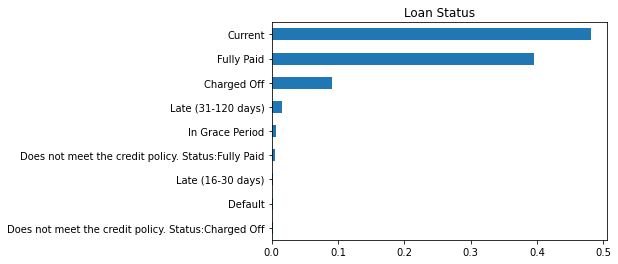

In [40]:
# Plot it as a bar chart
data.loan_status.value_counts(normalize=True).sort_values().plot(kind='barh')
plt.title('Loan Status')
plt.show()

In [41]:
# Create a new column based on loan_status thatt will be our target variable
# 1 - Good Loan (Fully Paid, Current, In Grace Period)
# 0 - Bad Loan (Charged Off, Default, Late (31-120 days), Does not meet the credit policy. Status:Charged Off)
data['good_bad'] = np.where(data.loc[:, 'loan_status'].isin(['Charged Off', 'Default', 'Late (31-120 days)',
                                                                       'Does not meet the credit policy. Status:Charged Off']), 0, 1)


# Drop the original 'loan_status' column
data.drop(columns = ['loan_status'], inplace = True)

In [42]:
data['good_bad'].value_counts(normalize=True)

1    0.890693
0    0.109307
Name: good_bad, dtype: float64

## Split the data into train and test

In [43]:
# Split the data into train and test (80-20 split)
# Use random_state = 42 to ensure that the results are reproducible
# Use stratify to ensure that the proportion of good and bad loans is the same in both train and test sets
X = data.drop(columns = 'good_bad')
y = data['good_bad']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


X_train, X_test = X_train.copy(), X_test.copy()

In [44]:
# Check the shape of the train and test sets
X_train.shape, X_test.shape

((373028, 42), (93257, 42))

## Data Cleaning / Preprocessing

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466285 entries, 0 to 466284
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   loan_amnt                    466285 non-null  int64  
 1   funded_amnt                  466285 non-null  int64  
 2   funded_amnt_inv              466285 non-null  float64
 3   term                         466285 non-null  object 
 4   int_rate                     466285 non-null  float64
 5   installment                  466285 non-null  float64
 6   grade                        466285 non-null  object 
 7   emp_length                   445277 non-null  object 
 8   home_ownership               466285 non-null  object 
 9   annual_inc                   466281 non-null  float64
 10  verification_status          466285 non-null  object 
 11  issue_d                      466285 non-null  object 
 12  pymnt_plan                   466285 non-null  object 
 13 

In [46]:
data.head()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_d,last_pymnt_amnt,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,good_bad
0,5000,5000,4975.0,36 months,10.65,162.87,B,10+ years,RENT,24000.0,Verified,Dec-11,n,credit_card,AZ,27.65,0.0,Jan-85,1.0,NaN,3.0,0.0,13648,83.7,9.0,f,0.0,0.0,5861.071414,5831.78,861.07,Jan-15,171.62,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
1,2500,2500,2500.0,60 months,15.27,59.83,C,< 1 year,RENT,30000.0,Source Verified,Dec-11,n,car,GA,1.00,0.0,Apr-99,5.0,NaN,3.0,0.0,1687,9.4,4.0,f,0.0,0.0,1008.710000,1008.71,435.17,Apr-13,119.66,Sep-13,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,0
2,2400,2400,2400.0,36 months,15.96,84.33,C,10+ years,RENT,12252.0,Not Verified,Dec-11,n,small_business,IL,8.72,0.0,Nov-01,2.0,NaN,2.0,0.0,2956,98.5,10.0,f,0.0,0.0,3003.653644,3003.65,603.65,Jun-14,649.91,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
3,10000,10000,10000.0,36 months,13.49,339.31,C,10+ years,RENT,49200.0,Source Verified,Dec-11,n,other,CA,20.00,0.0,Feb-96,1.0,35.0,10.0,0.0,5598,21.0,37.0,f,0.0,0.0,12226.302210,12226.30,2209.33,Jan-15,357.48,Jan-15,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1
4,3000,3000,3000.0,60 months,12.69,67.79,B,1 year,RENT,80000.0,Source Verified,Dec-11,n,other,OR,17.94,0.0,Jan-96,0.0,38.0,15.0,0.0,27783,53.9,38.0,f,766.9,766.9,3242.170000,3242.17,1009.07,Jan-16,67.79,Jan-16,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,1


In [47]:
# emp_length

def emp_length_converter(df, column):
    df[column] = df[column].str.replace('\+ years', '')
    df[column] = df[column].str.replace('< 1 year', str(0))
    df[column] = df[column].str.replace(' years', '')
    df[column] = df[column].str.replace(' year', '')
    df[column] = pd.to_numeric(df[column])
    df[column].fillna(value = 0, inplace = True)

# Apply to X_train
emp_length_converter(X_train, 'emp_length')

# X_train['emp_length'].value_counts()
X_train['emp_length'].unique()

'''
# Is this wise to do? 
# We have variables like: < 1 year and 10+ years which are ordinal in nature
# We are converting them to numeric variables which are not ordinal in nature
# We are assuming that 10+ years is greater than 1 year which is not true

# We can use One-Hot Encoding to convert these variables to numeric variables
# We can also use Ordinal Encoding to convert these variables to ordinal variables

# We will use Ordinal Encoding here
# We will create a dictionary that will map the values to the respective numbers
# We will then use the map function to map the values to the respective numbers

# Create a dictionary
emp_length_dict = {k: v for v, k in enumerate(sorted(X_train['emp_length'].unique()))}

# Map it to the emp_length column
X_train['emp_length'] = X_train['emp_length'].map(emp_length_dict)
'''

"\n# Is this wise to do? \n# We have variables like: < 1 year and 10+ years which are ordinal in nature\n# We are converting them to numeric variables which are not ordinal in nature\n# We are assuming that 10+ years is greater than 1 year which is not true\n\n# We can use One-Hot Encoding to convert these variables to numeric variables\n# We can also use Ordinal Encoding to convert these variables to ordinal variables\n\n# We will use Ordinal Encoding here\n# We will create a dictionary that will map the values to the respective numbers\n# We will then use the map function to map the values to the respective numbers\n\n# Create a dictionary\nemp_length_dict = {k: v for v, k in enumerate(sorted(X_train['emp_length'].unique()))}\n\n# Map it to the emp_length column\nX_train['emp_length'] = X_train['emp_length'].map(emp_length_dict)\n"

In [48]:
# Convert date columns to datetime format
# And create a new column as a difference between today and the respective date column

def date_converter(df, column):
    # store current month
    today_date = pd.to_datetime('2023-05-14')
    # convert to datetime format
    df[column] = pd.to_datetime(df[column], format = "%b-%y")
    # calculate the difference in months and add to a new column
    df['mths_since_' + column] = round(pd.to_numeric((today_date - df[column]) / np.timedelta64(1, 'M')))
    # make any resulting -ve values to be equal to the max date
    df['mths_since_' + column] = df['mths_since_' + column].apply(lambda x: df['mths_since_' + column].max() if x < 0 else x)
    # drop the original date column
    df.drop(columns = [column], inplace = True)

# apply to X_train
date_converter(X_train, 'earliest_cr_line')
date_converter(X_train, 'issue_d')
date_converter(X_train, 'last_pymnt_d')
date_converter(X_train, 'last_credit_pull_d')

# let's check these new columns
print(X_train['mths_since_earliest_cr_line'].describe())
print(X_train['mths_since_issue_d'].describe())
print(X_train['mths_since_last_pymnt_d'].describe())
print(X_train['mths_since_last_credit_pull_d'].describe())

count    373003.000000
mean        307.293609
std          86.372742
min         138.000000
25%         248.000000
50%         290.000000
75%         350.000000
max         652.000000
Name: mths_since_earliest_cr_line, dtype: float64
count    373028.000000
mean        116.252485
std          14.339074
min         101.000000
25%         106.000000
50%         112.000000
75%         122.000000
max         191.000000
Name: mths_since_issue_d, dtype: float64
count    372717.000000
mean         96.289989
std          12.803859
min          88.000000
25%          88.000000
50%          89.000000
75%         100.000000
max         185.000000
Name: mths_since_last_pymnt_d, dtype: float64
count    372998.000000
mean         92.041810
std           9.630887
min          88.000000
25%          88.000000
50%          88.000000
75%          90.000000
max         192.000000
Name: mths_since_last_credit_pull_d, dtype: float64


In [49]:
# term column = 36 months, 60 months
# X_train['term'].value_counts()
# remove ' months' from the values and convert to numeric
X_train['term'] = X_train['term'].str.replace(' months', '').astype(int)

In [50]:
X_train.sample(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_length,home_ownership,annual_inc,verification_status,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
19349,12000,12000,11975.0,36,7.29,372.12,A,9.0,RENT,36000.0,Source Verified,n,wedding,CA,4.27,0.0,0.0,NaN,6.0,0.0,5880,49.8,17.0,f,0.00,0.00,13224.00000,13196.46,1223.99,4677.58,0.0,NaN,1,INDIVIDUAL,0.0,NaN,NaN,NaN,279.0,147.0,122.0,90.0
423774,18000,18000,18000.0,60,16.59,443.39,D,9.0,MORTGAGE,67000.0,Source Verified,n,debt_consolidation,NY,21.36,0.0,0.0,32.0,11.0,1.0,14616,39.0,33.0,f,13297.18,13297.18,9311.19000,9311.19,4608.37,443.39,0.0,32.0,1,INDIVIDUAL,0.0,0.0,234210.0,37500.0,493.0,110.0,88.0,88.0
370973,21675,21675,21675.0,60,22.15,600.49,E,2.0,OWN,60000.0,Verified,n,debt_consolidation,FL,9.54,0.0,1.0,NaN,19.0,1.0,5816,16.4,25.0,w,0.00,0.00,27650.34000,27650.34,5975.34,18642.99,0.0,NaN,1,INDIVIDUAL,0.0,1902.0,29502.0,35500.0,245.0,107.0,91.0,91.0
80612,20000,20000,20000.0,36,15.10,694.29,C,8.0,RENT,60000.0,Verified,n,small_business,CA,17.94,0.0,0.0,NaN,6.0,0.0,16707,74.3,14.0,f,0.00,0.00,24094.82903,24094.83,4094.83,10211.83,0.0,NaN,1,INDIVIDUAL,0.0,0.0,29658.0,22500.0,237.0,115.0,94.0,94.0
82582,20000,20000,19950.0,60,12.99,454.96,B,2.0,MORTGAGE,67000.0,Verified,n,debt_consolidation,WI,18.79,0.0,0.0,62.0,11.0,0.0,26195,65.8,34.0,f,11166.56,11138.65,13496.44000,13462.69,4663.00,500.00,0.0,NaN,1,INDIVIDUAL,0.0,219.0,316413.0,39800.0,318.0,115.0,88.0,88.0


In [51]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 42 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   funded_amnt_inv                373028 non-null  float64
 3   term                           373028 non-null  int64  
 4   int_rate                       373028 non-null  float64
 5   installment                    373028 non-null  float64
 6   grade                          373028 non-null  object 
 7   emp_length                     373028 non-null  float64
 8   home_ownership                 373028 non-null  object 
 9   annual_inc                     373024 non-null  float64
 10  verification_status            373028 non-null  object 
 11  pymnt_plan                     373028 non-null  object 
 12  purpose                   

## Feature Selection

In [52]:
# First divide training data into categorical and numerical subsets
X_train_num = X_train.select_dtypes(include = np.number).copy()
X_train_cat = X_train.select_dtypes(include = np.object).copy()

## Chi-squared statistic for categorical variables

In [66]:
# initialize an empty dictionary to store the results of chi-square test
chi_sq_results = {}

# loop over all the categorical variables
for col in X_train_cat.columns:
    chi, pi, dof, expected = chi2_contingency(pd.crosstab(y_train, X_train_cat[col]))
    # chi_sq_results[col] = {'chi_sq': chi, 'p_value': pi, 'dof': dof}
    chi_sq_results.setdefault('Feature', []).append(col)
    # chi_sq_results.setdefault('p-value', []).append(round(pi, 10))
    chi_sq_results.setdefault('p-value', []).append(pi)

# convert the dictionary to a dataframe
chi_sq_results = pd.DataFrame(chi_sq_results)

# sort the dataframe by p_value
chi_sq_results = chi_sq_results.sort_values(by = 'p-value', ascending = False, ignore_index=True )

chi_sq_results


,Feature,p-value
0,application_type,1.000000e+00
1,pymnt_plan,9.234213e-04
2,addr_state,1.008748e-64
3,home_ownership,5.773889e-171
4,verification_status,2.703493e-180
5,initial_list_status,8.341789e-194
6,purpose,2.410054e-307
7,grade,0.000000e+00


We will use the chi-squared statistic to identify the categorical variables that are most predictive of the target variable. We will select the top 4 variables.
Those columns are: 'application_type', 'pymnt_plan', 'addr_state', 'home_ownership'

## ANOVA F-Statistic for numerical variables

In [80]:
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   funded_amnt_inv                373028 non-null  float64
 3   term                           373028 non-null  int64  
 4   int_rate                       373028 non-null  float64
 5   installment                    373028 non-null  float64
 6   emp_length                     373028 non-null  float64
 7   annual_inc                     373024 non-null  float64
 8   dti                            373028 non-null  float64
 9   delinq_2yrs                    373003 non-null  float64
 10  inq_last_6mths                 373003 non-null  float64
 11  mths_since_last_delinq         172651 non-null  float64
 12  open_acc                  

In [82]:
# Since f_class_if does not accept missing values, wee will do a avery crude imputation of missing values
X_train_num.fillna(X_train_num.mean(), inplace = True)

# Calculate the F Statistic and corresponding p value
f_stat, p_value = f_classif(X_train_num, y_train)

# Create a dataframe to store the results
ANOVA_F_table = pd.DataFrame(data = {'Numerical_Feature': X_train_num.columns.values, 'F-Score': f_stat, 'p values': p_value.round(decimals=10)})
ANOVA_F_table.sort_values(by = ['F-Score'], ascending = False, ignore_index = True, inplace = True)
ANOVA_F_table

,Numerical_Feature,F-Score,p values
0,mths_since_last_pymnt_d,23513.805570,0.000000e+00
1,total_pymnt_inv,14784.534040,0.000000e+00
2,total_pymnt,14686.729567,0.000000e+00
3,int_rate,11462.788313,0.000000e+00
4,last_pymnt_amnt,10826.949727,0.000000e+00
5,out_prncp,9635.116160,0.000000e+00
6,out_prncp_inv,9633.442129,0.000000e+00
7,mths_since_last_credit_pull_d,7020.218888,0.000000e+00
8,mths_since_issue_d,2816.028871,0.000000e+00
9,inq_last_6mths,2003.820465,0.000000e+00


In [93]:
X_train_num.policy_code.value_counts()

1    373028
Name: policy_code, dtype: int64

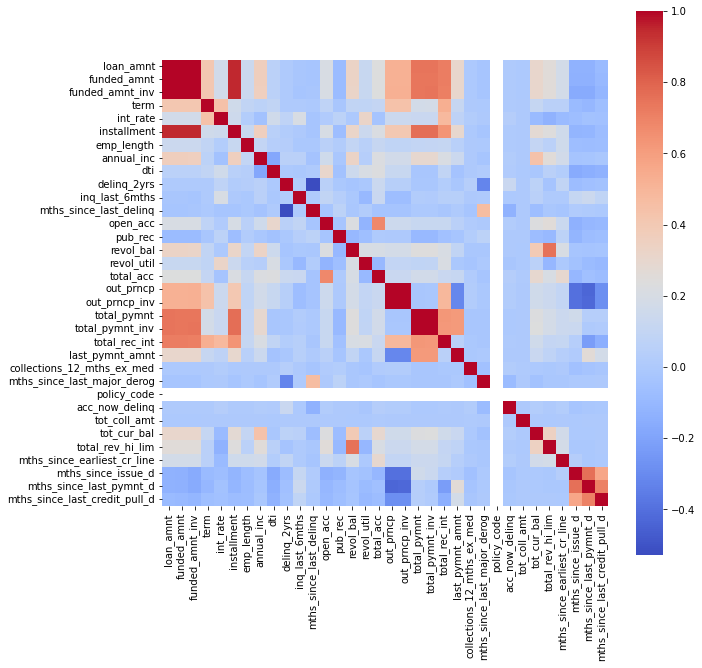

In [99]:
# # Keep the top 20 numerical features
# top_num_features = ANOVA_F_table.iloc[:20, 0].tolist()
# # Calculate the pair-wise correlations between the variables
# corrmat = X_train_num[top_num_features].corr()
# plt.figure(figsize = (10, 10))
# sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');


# Do it again for all the features
corrmat = X_train_num.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(corrmat, annot = False, square = True, cmap = 'coolwarm');



The ANOVA F-Statistic is used to identify the numerical variables that are most predictive of the target variable. We will select the top 4 variables. Those columns are: 'total_rec_late_fee', 'total_rec_int', 'total_rec_prncp', 'recoveries'

In [96]:
X_train_num.sample(5)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_int,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,mths_since_earliest_cr_line,mths_since_issue_d,mths_since_last_pymnt_d,mths_since_last_credit_pull_d
284687,8025,8025,8025.0,36,18.99,294.13,0.0,63425.64,20.62,1.0,5.0,29.000000,9.0,1.0,4810,70.0,26.0,0.00,0.00,9563.64000,9563.64,1538.64,5748.42,0.0,13.000000,1,0.0,0.000000,351465.000000,6900.000000,554.0,103.0,89.0,88.0
465840,15000,15000,15000.0,36,11.99,498.15,10.0,60000.00,9.16,0.0,1.0,34.113454,7.0,0.0,11032,58.7,28.0,0.00,0.00,17206.61000,17206.61,2206.61,8738.06,0.0,42.845603,1,0.0,0.000000,14889.000000,18800.000000,387.0,112.0,94.0,94.0
225426,30000,30000,30000.0,60,16.29,734.18,5.0,60000.00,15.20,0.0,1.0,34.113454,12.0,0.0,26197,57.1,26.0,0.00,0.00,38122.43000,38122.43,8122.43,21990.47,0.0,42.845603,1,0.0,201.348743,139090.706582,30400.635424,451.0,134.0,111.0,112.0
421356,15000,15000,15000.0,36,8.90,476.30,10.0,38000.00,14.40,0.0,0.0,34.113454,8.0,0.0,7235,74.6,18.0,6452.18,6452.18,10252.30000,10252.30,1704.48,476.30,0.0,42.845603,1,0.0,0.000000,15106.000000,9700.000000,297.0,109.0,88.0,88.0
163012,22000,22000,22000.0,36,8.90,698.58,7.0,80000.00,21.65,0.0,0.0,34.113454,12.0,0.0,25581,72.9,27.0,0.00,0.00,24960.86552,24960.87,2960.87,6810.77,0.0,42.845603,1,0.0,0.000000,132254.000000,35086.000000,317.0,122.0,95.0,89.0


In [97]:
X_train_num.out_prncp.value_counts()

0.00       183962
5684.61        71
6563.61        64
5709.44        63
5617.88        62
            ...  
8355.68         1
3886.52         1
2903.00         1
1127.90         1
9947.82         1
Name: out_prncp, Length: 112954, dtype: int64

In [98]:
X_train_num.out_prncp_inv.value_counts()

0.00        183962
5684.61         68
6563.61         63
5617.88         60
5709.44         59
             ...  
9293.36          1
6587.68          1
2965.85          1
11288.70         1
9898.75          1
Name: out_prncp_inv, Length: 117366, dtype: int64

In [76]:
from sklearn.linear_model import Lasso
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load the dataset

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_num)


# Create and fit the LASSO model
lasso = Lasso(alpha=0.1)  # Adjust the alpha value to control the degree of regularization
lasso.fit(X_train_num, y_train)

# Retrieve the selected features
selected_features = [feature for feature, coef in zip(data.feature_names, lasso.coef_) if coef != 0]

# Print the selected features
print("Selected features:")
for feature in selected_features:
    print(feature)


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [78]:
#
X_train_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 373028 entries, 456615 to 38736
Data columns (total 34 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   loan_amnt                      373028 non-null  int64  
 1   funded_amnt                    373028 non-null  int64  
 2   funded_amnt_inv                373028 non-null  float64
 3   term                           373028 non-null  int64  
 4   int_rate                       373028 non-null  float64
 5   installment                    373028 non-null  float64
 6   emp_length                     373028 non-null  float64
 7   annual_inc                     373024 non-null  float64
 8   dti                            373028 non-null  float64
 9   delinq_2yrs                    373003 non-null  float64
 10  inq_last_6mths                 373003 non-null  float64
 11  mths_since_last_delinq         172651 non-null  float64
 12  open_acc                  

In [79]:
X_train_num.isnull().sum()

loan_amnt                             0
funded_amnt                           0
funded_amnt_inv                       0
term                                  0
int_rate                              0
installment                           0
emp_length                            0
annual_inc                            4
dti                                   0
delinq_2yrs                          25
inq_last_6mths                       25
mths_since_last_delinq           200377
open_acc                             25
pub_rec                              25
revol_bal                             0
revol_util                          264
total_acc                            25
out_prncp                             0
out_prncp_inv                         0
total_pymnt                           0
total_pymnt_inv                       0
total_rec_int                         0
last_pymnt_amnt                       0
collections_12_mths_ex_med          122
mths_since_last_major_derog      293778


In [77]:
# Detect outliers in the training dataset
from sklearn.ensemble import IsolationForest

# Create the isolation forest model
isolation_forest = IsolationForest(n_estimators=100, contamination=0.01)

# Fit the model
isolation_forest.fit(X_train_num)

# Use the model to detect outliers
outliers = isolation_forest.predict(X_train_num)

# Print the outlier cases
print("Outlier cases:")
print(X_train_num[outliers == -1])



ValueError: Input contains NaN, infinity or a value too large for dtype('float64').